In [1]:
import sys

# Define the branch you want to install from
branch = "master"

# Install dependencies whether in Colab or not
#!pip install --quiet --upgrade jsonschema
#!pip install --quiet git+https://github.com/yoseflab/hotspot@$branch
#!pip install --quiet scanpy
#!pip install --quiet muon
#!pip install --quiet mplscience

In [ ]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
# import muon as mu

import numpy as np
import mplscience

import matplotlib.pyplot as plt

import pickle

import pandas as pd

Processing sample: Neutrophil


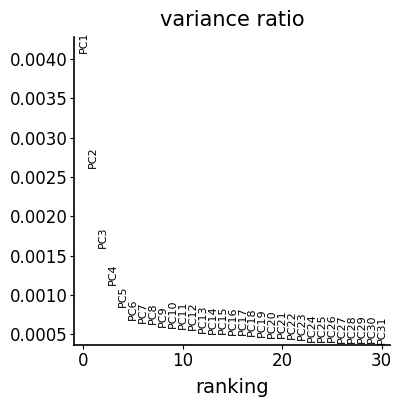

100%|██████████| 19255/19255 [01:14<00:00, 256.76it/s]


Computing pair-wise local correlation on 917 features...


100%|██████████| 419986/419986 [16:06<00:00, 434.37it/s]


Module
 6     172
-1     126
 1      83
 3      38
 9      38
 7      37
 2      33
 15     30
 12     29
 4      29
 11     29
 19     28
 8      26
 5      26
 18     20
 10     19
 20     19
 27     18
 24     15
 16     13
 14     12
 13     12
 25     12
 23     11
 26     11
 21     11
 17     10
 22     10
Name: count, dtype: int64
Processing sample: Endothelial


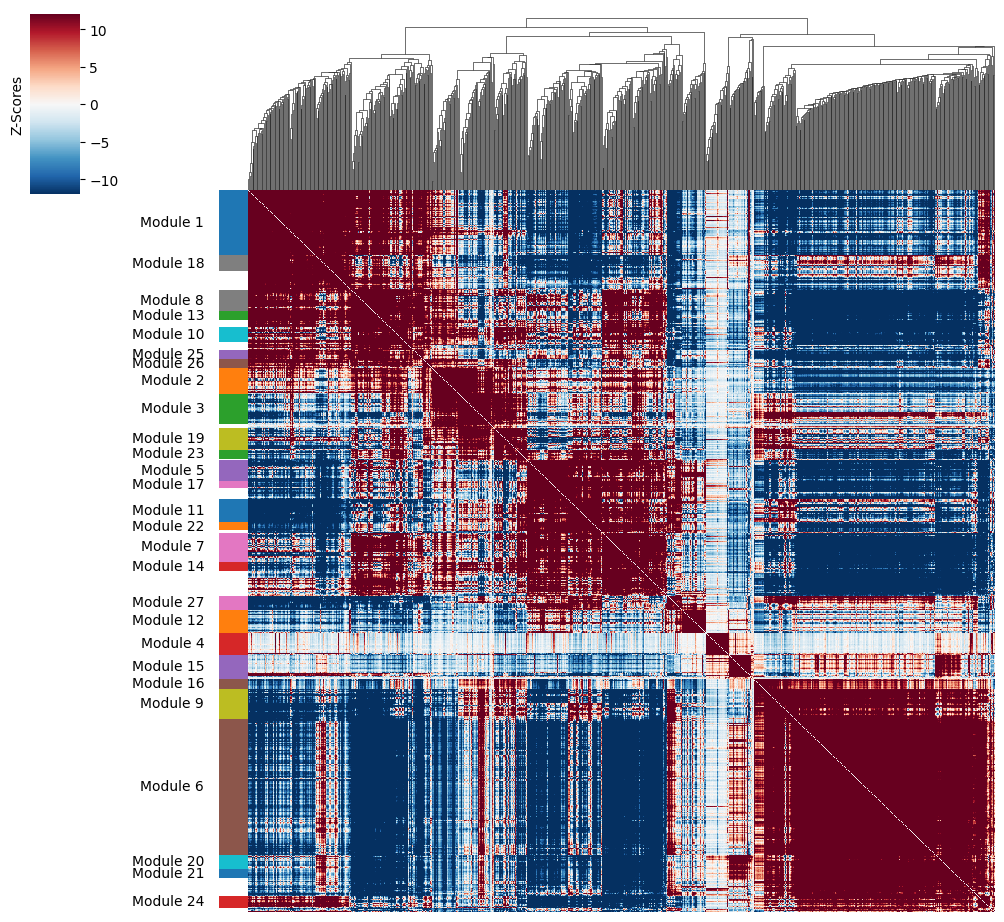

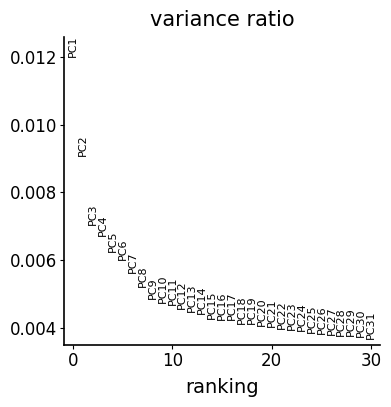

100%|██████████| 14272/14272 [00:04<00:00, 2946.14it/s]


Computing pair-wise local correlation on 930 features...


100%|██████████| 431985/431985 [00:15<00:00, 27061.93it/s]


Module
-1     190
 4      83
 1      83
 2      57
 3      53
 12     44
 13     32
 14     24
 28     23
 5      21
 20     21
 11     20
 18     19
 17     19
 27     17
 6      17
 24     16
 9      16
 26     15
 15     15
 16     15
 21     14
 31     13
 7      13
 10     12
 19     12
 22     12
 23     11
 29     11
 25     11
 8      11
 30     10
Name: count, dtype: int64


In [6]:
samples = ['PTOI3']

# Loop through each sample
for sample in samples:
    print(f"Processing sample: {sample}")
    
    # Load the .h5ad file for the current sample
    adata_cd4 = sc.read(f'/gpfs/data/yanailab/projects/dl4564/PTOI/objects/{sample}.h5ad')

    # Perform preprocessing and PCA
    adata_cd4.layers["counts"] = adata_cd4.raw.X
    sc.pp.filter_genes(adata_cd4, min_cells=1)
    sc.pp.normalize_total(adata_cd4)
    sc.pp.log1p(adata_cd4)
    adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
    sc.pp.scale(adata_cd4)
    sc.tl.pca(adata_cd4)

    # Plot PCA variance ratio
    with mplscience.style_context():
        sc.pl.pca_variance_ratio(adata_cd4)

    # Rerun PCA with fewer components
    sc.tl.pca(adata_cd4, n_comps=8)

    # Create the Hotspot object and neighborhood graph
    adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()
    hs = hotspot.Hotspot(
        adata_cd4,
        layer_key="counts_csc",
        model='danb',
        latent_obsm_key="X_pca",
        umi_counts_obs_key="nCount_RNA"
    )

    hs.create_knn_graph(weighted_graph=False, n_neighbors=50)
    hs_results = hs.compute_autocorrelations(jobs=4)

    # Sort by 'Z' and select the top 1000 genes
    hs_genes = hs_results.sort_values('Z', ascending=False).head(1000).index

    # Exclude genes that start with 'mt-', 'Rpl', or 'Rps'
    exclude_patterns = ['^mt-', '^Rpl', '^Rps']
    for pattern in exclude_patterns:
        hs_genes = hs_genes[~hs_genes.str.contains(pattern, regex=True)]

    # Compute pairwise local correlations between the selected genes
    lcz = hs.compute_local_correlations(hs_genes, jobs=4)

    # Create modules based on local correlations
    modules = hs.create_modules(
        min_gene_threshold=10, core_only=True, fdr_threshold=0.05
    )

    # Print the module value counts
    print(modules.value_counts())

    # Plot local correlations and save the plot
    hs.plot_local_correlations(vmin=-12, vmax=12)
    plt.savefig(f"/gpfs/data/yanailab/projects/dl4564/PTOI/modules/{sample}/hotspot_local_correlations.png")

    # Save the modules and plot for the current sample
    modules.to_csv(f'/gpfs/data/yanailab/projects/dl4564/PTOI/modules/{sample}/hotspot.modules.csv', header=True)
    
        # Save the gene - gene zscore correlation matrix!
    hs.local_correlation_z.to_csv(f"/gpfs/data/yanailab/projects/dl4564/PTOI/modules/{sample}/zscore_correlation_hotspot.csv")

    # Save the Hotspot object for the current sample
    with open(f'/gpfs/data/yanailab/projects/dl4564/PTOI/objects/{sample}_hotspot.pkl', 'wb') as f:
        pickle.dump(hs, f)